In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import glob
import os
import sklearn.model_selection

In [2]:

metadata = pd.read_csv('metadata.csv')
metadata = metadata[['isic_id','age_approx','clin_size_long_diam_mm','sex','diagnosis_1', 'diagnosis']]
# encode columns
metadata['sex'] = metadata['sex'].map({'male': 0, 'female': 1})

metadata['benignORmalignant'] = metadata['diagnosis_1']
metadata['diagnosis_1'] = metadata['diagnosis_1'].map({'Benign': 0, 'Malignant': 1})

# missing values
metadata['age_approx'] = metadata['age_approx'].fillna(metadata['age_approx'].mean())
metadata['clin_size_long_diam_mm'] = metadata['clin_size_long_diam_mm'].fillna(metadata['clin_size_long_diam_mm'].mean())
metadata = metadata.dropna()

# Create filename field
metadata['filename'] = metadata['isic_id'].astype(str) + '.jpg'


/var/folders/0b/33n254b510726mq07nrfcfbw0000gn/T/ipykernel_10153/3712885323.py:1: DtypeWarning: Columns (6,9,10,11,13,14,15,16,17,18,19,22,23,25,26,27,28,30,35) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('metadata.csv')


In [3]:
metadata = metadata[metadata['benignORmalignant'] != 'Indeterminate']

In [4]:
metadata.head()

,isic_id,age_approx,clin_size_long_diam_mm,sex,diagnosis_1,diagnosis,benignORmalignant,filename
3012,ISIC_7559201,55.0,6.6,1.0,0.0,nevus,Benign,ISIC_7559201.jpg
3014,ISIC_5257439,40.0,4.2,1.0,0.0,nevus,Benign,ISIC_5257439.jpg
3017,ISIC_0469776,50.0,3.9,1.0,0.0,nevus,Benign,ISIC_0469776.jpg
3020,ISIC_1648650,40.0,4.2,1.0,0.0,nevus,Benign,ISIC_1648650.jpg
3021,ISIC_7529219,30.0,6.6,1.0,0.0,nevus,Benign,ISIC_7529219.jpg


In [5]:
diag1_malignant_df = metadata[metadata['benignORmalignant']=='Malignant']

In [6]:
diag1_malignant_df.head()

,isic_id,age_approx,clin_size_long_diam_mm,sex,diagnosis_1,diagnosis,benignORmalignant,filename
3025,ISIC_7244280,65.0,8.7,1.0,1.0,melanoma,Malignant,ISIC_7244280.jpg
3046,ISIC_5054247,65.0,8.7,1.0,1.0,melanoma,Malignant,ISIC_5054247.jpg
3053,ISIC_6683697,65.0,8.7,1.0,1.0,melanoma,Malignant,ISIC_6683697.jpg
3055,ISIC_1633321,80.0,10.1,0.0,1.0,melanoma,Malignant,ISIC_1633321.jpg
3061,ISIC_8353193,65.0,8.7,1.0,1.0,melanoma,Malignant,ISIC_8353193.jpg


In [7]:
diag1_malignant_df['diagnosis'].value_counts()

diagnosis
melanoma                   8752
basal cell carcinoma       5901
squamous cell carcinoma    1575
melanoma metastasis         687
seborrheic keratosis         17
solar lentigo                 5
Name: count, dtype: int64

In [8]:
metadata['diagnosis'].value_counts()
#drop malignant AND have these: 'seborrheic keratosis', 'solar lentigo', 'other' 
# where malignant in diagnosis_1, use diagnosis value

diagnosis
nevus                             36708
melanoma                           8752
basal cell carcinoma               5901
seborrheic keratosis               2364
squamous cell carcinoma            1575
pigmented benign keratosis         1254
melanoma metastasis                 687
solar lentigo                       659
dermatofibroma                      447
scar                                385
vascular lesion                     372
lichenoid keratosis                 331
acrochordon                         302
lentigo NOS                         275
verruca                             117
angioma                              71
lentigo simplex                      54
other                                35
neurofibroma                         26
angiokeratoma                        11
sebaceous hyperplasia                 7
angiofibroma or fibrous papule        6
clear cell acanthoma                  6
adnexal tumor                         3
pyogenic granuloma            

In [9]:
metadata['benignORmalignant'].value_counts()

benignORmalignant
Benign       43421
Malignant    16937
Name: count, dtype: int64

In [10]:
# Drop rows where diagnosis_1 is 'Malignant' AND diagnosis is in the specified list
metadata = metadata[~((metadata['benignORmalignant'] == 'Malignant') & 
                       (metadata['diagnosis'].isin(['seborrheic keratosis', 'solar lentigo', 'other'])))]

In [11]:
metadata['target'] = metadata['benignORmalignant'].apply(lambda x: 'Benign' if x == 'Benign' else np.nan)

In [12]:
metadata['target'] = metadata.apply(
    lambda row: row['diagnosis'] if row['benignORmalignant'] == 'Malignant' else row['target'], 
    axis=1
)

In [13]:
metadata['target'].value_counts()

target
Benign                     43421
melanoma                    8752
basal cell carcinoma        5901
squamous cell carcinoma     1575
melanoma metastasis          687
Name: count, dtype: int64

In [14]:
metadata['target'].isna().sum()

0

In [15]:
metadata_encoded = pd.get_dummies(metadata, columns=['target'])
bool_cols = metadata_encoded.select_dtypes(bool).columns
metadata_encoded[bool_cols] = metadata_encoded[bool_cols].astype(int)

In [16]:
metadata_encoded.head()

,isic_id,age_approx,clin_size_long_diam_mm,sex,diagnosis_1,diagnosis,benignORmalignant,filename,target_Benign,target_basal cell carcinoma,target_melanoma,target_melanoma metastasis,target_squamous cell carcinoma
3012,ISIC_7559201,55.0,6.6,1.0,0.0,nevus,Benign,ISIC_7559201.jpg,1,0,0,0,0
3014,ISIC_5257439,40.0,4.2,1.0,0.0,nevus,Benign,ISIC_5257439.jpg,1,0,0,0,0
3017,ISIC_0469776,50.0,3.9,1.0,0.0,nevus,Benign,ISIC_0469776.jpg,1,0,0,0,0
3020,ISIC_1648650,40.0,4.2,1.0,0.0,nevus,Benign,ISIC_1648650.jpg,1,0,0,0,0
3021,ISIC_7529219,30.0,6.6,1.0,0.0,nevus,Benign,ISIC_7529219.jpg,1,0,0,0,0


In [17]:
#above is all pretty much changed/added

In [18]:
'''
good_image_paths = []

for path in valid_image_paths:
    try:
        img_raw = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img_raw, channels=3)
        good_image_paths.append(path)
    except:
        print(f"Skipping invalid image: {path}")

with open('good_image_paths.txt', 'w') as f:
    for path in good_image_paths:
        f.write(f"{path}\n")
'''

'\ngood_image_paths = []\n\nfor path in valid_image_paths:\n    try:\n        img_raw = tf.io.read_file(path)\n        img = tf.image.decode_jpeg(img_raw, channels=3)\n        good_image_paths.append(path)\n    except:\n        print(f"Skipping invalid image: {path}")\n\nwith open(\'good_image_paths.txt\', \'w\') as f:\n    for path in good_image_paths:\n        f.write(f"{path}\n")\n'

In [19]:
with open('good_image_paths.txt', 'r') as f:
    image_paths = [line.strip() for line in f]

filenames = [os.path.basename(p) for p in image_paths]
metadata = metadata[metadata['filename'].isin(filenames)].reset_index(drop=True)


In [20]:
# Create lookup dictionaries
label_lookup = dict(zip(metadata['filename'], metadata['target']))

sex_lookup = dict(zip(metadata['filename'], metadata['sex']))
age_lookup = dict(zip(metadata['filename'], metadata['age_approx']))
size_lookup = dict(zip(metadata['filename'], metadata['clin_size_long_diam_mm']))

# Lists for matched data
valid_image_paths = []
labels = []
sex_features = []
age_features = []
size_features = []

# Get all unique classes from 'target' and create index mapping
all_classes = sorted(metadata['target'].unique())
class_to_index = {name: i for i, name in enumerate(all_classes)}


for path, fname in zip(image_paths, filenames):
    if fname in label_lookup:
        valid_image_paths.append(path)
        target_str = label_lookup[fname]
        class_index = class_to_index[target_str]
        labels.append(class_index)
        sex_features.append(sex_lookup[fname])
        age_features.append(age_lookup[fname])
        size_features.append(size_lookup[fname])



In [21]:
trainval_paths, test_paths, trainval_labels, test_labels, \
trainval_sex, test_sex, trainval_age, test_age, trainval_size, test_size = sklearn.model_selection.train_test_split(
    valid_image_paths, labels, sex_features, age_features, size_features,
    test_size=0.1, random_state=42, shuffle=True
)


In [22]:
len(trainval_paths)

54302

In [23]:
len(test_paths)

6034

In [24]:
from collections import defaultdict
import numpy as np
import shutil
import os

# Group paths by label
label_to_paths = defaultdict(list)
for path, label in zip(trainval_paths, trainval_labels):
    label_to_paths[label].append(path)

# Initialize output lists
train_paths, val_paths, train_labels, val_labels = [], [], [], []

np.random.seed(42)
for label, paths in label_to_paths.items():
    if len(paths) < 500:
        print(f" Skipping label {label} (only {len(paths)} images available)")
        continue

    sampled_paths = np.random.choice(paths, 500, replace=False)
    train_p = sampled_paths[:400]
    val_p = sampled_paths[400:]

    train_paths.extend(train_p)
    train_labels.extend([label] * len(train_p))

    val_paths.extend(val_p)
    val_labels.extend([label] * len(val_p))

# Create new folders for train/val
for folder in ['images_train_balanced', 'images_val_balanced']:
    os.makedirs(folder, exist_ok=True)

# Copy files into folders
for path in train_paths:
    shutil.copy(path, f'images_train_balanced/{os.path.basename(path)}')

for path in val_paths:
    shutil.copy(path, f'images_val_balanced/{os.path.basename(path)}')


In [25]:

import os
import shutil
os.makedirs('./images_test2', exist_ok=True)

for path in test_paths:
    filename = os.path.basename(path)
    shutil.copy(path, f'./images_test2/{filename}')


In [26]:


train_image_ds = tf.keras.utils.image_dataset_from_directory(
    directory='images_train_balanced',
    labels=train_labels,
    label_mode='categorical',
    batch_size=64,
    image_size=(128, 128),
    shuffle=True,
    seed=123
)

val_image_ds = tf.keras.utils.image_dataset_from_directory(
    directory='images_val_balanced',
    labels=val_labels,
    label_mode='categorical',
    batch_size=64,
    image_size=(128, 128),
    shuffle=True,
    seed=123
)

Found 2000 files belonging to 5 classes.
Found 500 files belonging to 5 classes.


In [27]:
# Test filenames and labels
test_path_to_label = {os.path.basename(p): l for p, l in zip(test_paths, test_labels)}
test_filenames = [os.path.basename(p) for p in test_paths]
test_labels_sorted = [test_path_to_label[fname] for fname in test_filenames]

test_image_ds = tf.keras.utils.image_dataset_from_directory(
    directory='./images_test2',
    labels=test_labels_sorted,
    label_mode='categorical',
    batch_size=64,
    image_size=(128, 128),
    shuffle=False
)


Found 6034 files belonging to 5 classes.


In [28]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])
augmented_train_image_ds = train_image_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


In [29]:
train_metadata_ds = tf.data.Dataset.from_tensor_slices(
    tf.stack([trainval_sex[:len(train_image_ds)], trainval_age[:len(train_image_ds)], trainval_size[:len(train_image_ds)]], axis=1)
)

val_metadata_ds = tf.data.Dataset.from_tensor_slices(
    tf.stack([trainval_sex[len(train_image_ds):], trainval_age[len(train_image_ds):], trainval_size[len(train_image_ds):]], axis=1)
)

test_metadata_ds = tf.data.Dataset.from_tensor_slices(
    tf.stack([test_sex, test_age, test_size], axis=1)
)


In [30]:
train_images_only_ds = train_image_ds.map(lambda x, y: x)
train_labels_only_ds = train_image_ds.map(lambda x, y: y)

train_inputs_ds = tf.data.Dataset.zip((train_images_only_ds, train_metadata_ds))
final_train_ds = tf.data.Dataset.zip((train_inputs_ds, train_labels_only_ds)).prefetch(tf.data.AUTOTUNE)

val_images_only_ds = val_image_ds.map(lambda x, y: x)
val_labels_only_ds = val_image_ds.map(lambda x, y: y)

val_inputs_ds = tf.data.Dataset.zip((val_images_only_ds, val_metadata_ds))
final_val_ds = tf.data.Dataset.zip((val_inputs_ds, val_labels_only_ds)).prefetch(tf.data.AUTOTUNE)

test_images_only_ds = test_image_ds.map(lambda x, y: x)
test_labels_only_ds = test_image_ds.map(lambda x, y: y)

test_inputs_ds = tf.data.Dataset.zip((test_images_only_ds, test_metadata_ds))
final_test_ds = tf.data.Dataset.zip((test_inputs_ds, test_labels_only_ds)).prefetch(tf.data.AUTOTUNE)




In [31]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Set this based on your class mapping
num_classes = len(all_classes)  # all_classes = sorted(metadata['target'].unique())

# Load the base model
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model

# Add custom classification head
inputs = Input(shape=(128, 128, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)  # Multiclass classification
model = Model(inputs, outputs)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train top layers first
history = model.fit(train_image_ds,
                    validation_data=val_image_ds,
                    epochs=20,
                    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])
'''
# Unfreeze and fine-tune
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the whole model
history_finetune = model.fit(train_image_ds,
                             validation_data=val_image_ds,
                             epochs=50,
                             callbacks=[EarlyStopping(patience=8, restore_best_weights=True)])
'''

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - accuracy: 0.3148 - loss: 1.6359 - val_accuracy: 0.4000 - val_loss: 1.3307
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.3774 - loss: 1.3331 - val_accuracy: 0.4000 - val_loss: 1.3042
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.4118 - loss: 1.3075 - val_accuracy: 0.4260 - val_loss: 1.2798
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.4484 - loss: 1.2343 - val_accuracy: 0.4480 - val_loss: 1.2431
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.4754 - loss: 1.2212 - val_accuracy: 0.4260 - val_loss: 1.2482
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.5108 - loss: 1.1544 - val_accuracy: 0.4620 - val_loss: 1.2079
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.5284 - loss: 1.1272 - val_accuracy: 0.4700 - val_loss: 1.2061
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - accuracy: 0.5248 - loss: 1.1313 - val_accuracy: 0.

"\n# Unfreeze and fine-tune\nbase_model.trainable = True\nmodel.compile(optimizer=Adam(learning_rate=1e-5),\n              loss='categorical_crossentropy',\n              metrics=['accuracy'])\n\n# Fine-tune the whole model\nhistory_finetune = model.fit(train_image_ds,\n                             validation_data=val_image_ds,\n                             epochs=50,\n                             callbacks=[EarlyStopping(patience=8, restore_best_weights=True)])\n"

In [32]:
import numpy as np

y_true = []
y_pred = []

for images, labels in test_image_ds:
    preds = model.predict(images, verbose=0)               # shape: (batch_size, num_classes)
    y_pred.extend(np.argmax(preds, axis=1))                # Convert softmax output to predicted class index
    y_true.extend(np.argmax(labels.numpy(), axis=1))       # Convert one-hot labels to true class index

y_pred = np.array(y_pred)
y_true = np.array(y_true)


2025-05-14 23:18:04.483712: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


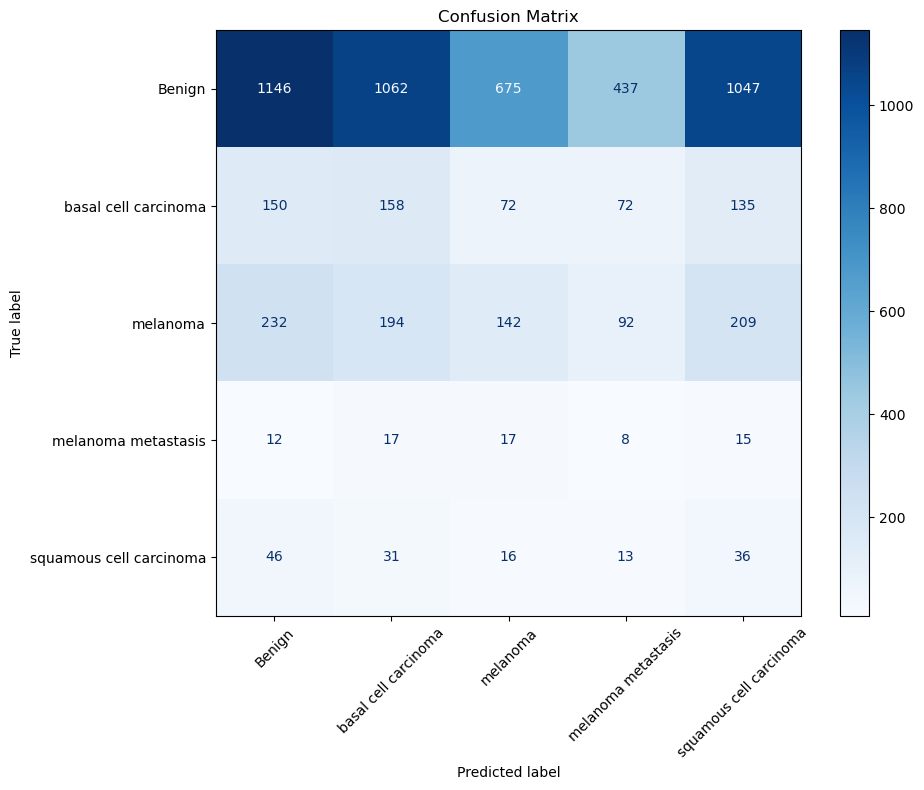

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(10, 8))  # You can adjust width and height here
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_classes)
disp.plot(cmap='Blues', values_format='d', ax=ax)
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=all_classes))


                         precision    recall  f1-score   support

                 Benign       0.72      0.26      0.39      4367
   basal cell carcinoma       0.11      0.27      0.15       587
               melanoma       0.15      0.16      0.16       869
    melanoma metastasis       0.01      0.12      0.02        69
squamous cell carcinoma       0.02      0.25      0.05       142

               accuracy                           0.25      6034
              macro avg       0.20      0.21      0.15      6034
           weighted avg       0.56      0.25      0.32      6034



In [35]:
model.save('model_multiclass_unfreeze.keras')